## ANLP Assignment 2: Text Generation
### Shuying Piao,  id: a1912828

In [1]:
import pandas as pd

### 1. Reading dataset and initial pre-processing

In [2]:
# Load and process a single dataset (train or test): expand 'ratings', retain other fields, and set 'review_id' as index.
def prepare_dataset(data_path):
    df = pd.read_json(data_path, lines=True)
    df = df.rename(columns={'id': 'review_id'})
    
    ratings_df = df['ratings'].apply(pd.Series)
    extra_columns = [col for col in df.columns if col not in ['text', 'title', 'ratings']]
    
    processed_df = pd.concat([ratings_df, df[extra_columns],df[['text']]], axis=1)
    processed_df = processed_df.set_index('review_id')
    
    return processed_df

In [3]:
train_df= prepare_dataset('hotel_reviews_train.JSON')
test_df= prepare_dataset('hotel_reviews_test.JSON')
train_df.head(3)

,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access),author,date_stayed,offering_id,num_helpful_votes,date,via_mobile,text
review_id,,,,,,,,,,,,,,,,
140716137,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,False,First of all we got there and they didn't have...
114807323,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,False,Found Racist graffiti in the room. Request to ...
84805430,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,False,Close to Union Square - hotel is a bit of a ma...


In [4]:
# View basic info of the training set: column data types, non-null counts
print("\nTrain Data Info:")
train_df.info()

# View basic info of the test set: column data types, non-null counts
print("\nTest Data Info:")
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 140716137 to 145539000
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   service                                 21550 non-null  float64       
 1   cleanliness                             21545 non-null  float64       
 2   overall                                 24000 non-null  float64       
 3   value                                   21547 non-null  float64       
 4   location                                18983 non-null  float64       
 5   sleep_quality                           14185 non-null  float64       
 6   rooms                                   20000 non-null  float64       
 7   check_in_front_desk                     2909 non-null   float64       
 8   business_service_(e_g_internet_access)  1959 non-null   float64       
 9   author                   

In [5]:
# Define a cleaning function for the target review text
import re

def clean_text_for_generation(text):
    if not isinstance(text, str):
        return ""
    
    text = re.sub(r'[^a-z0-9.,!?\'\";:\-\s]', '', text)  #keep English chars & punctuation
    text = text.lower()  # Convert to lowercase for easier word vector matching
    text = re.sub(r'<.*?>', '', text)  # Remove any HTML tags
    text = re.sub(r'[^\x00-\x7F]+', '', text)   # Remove non-ASCII characters (emoji, non-English characters)
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace by replacing multiple spaces with a single space
    return text.strip()


train_df['text'] = train_df['text'].apply(clean_text_for_generation)
test_df['text'] = test_df['text'].apply(clean_text_for_generation)

### 2. Exploratory Data Analysis (EDA)

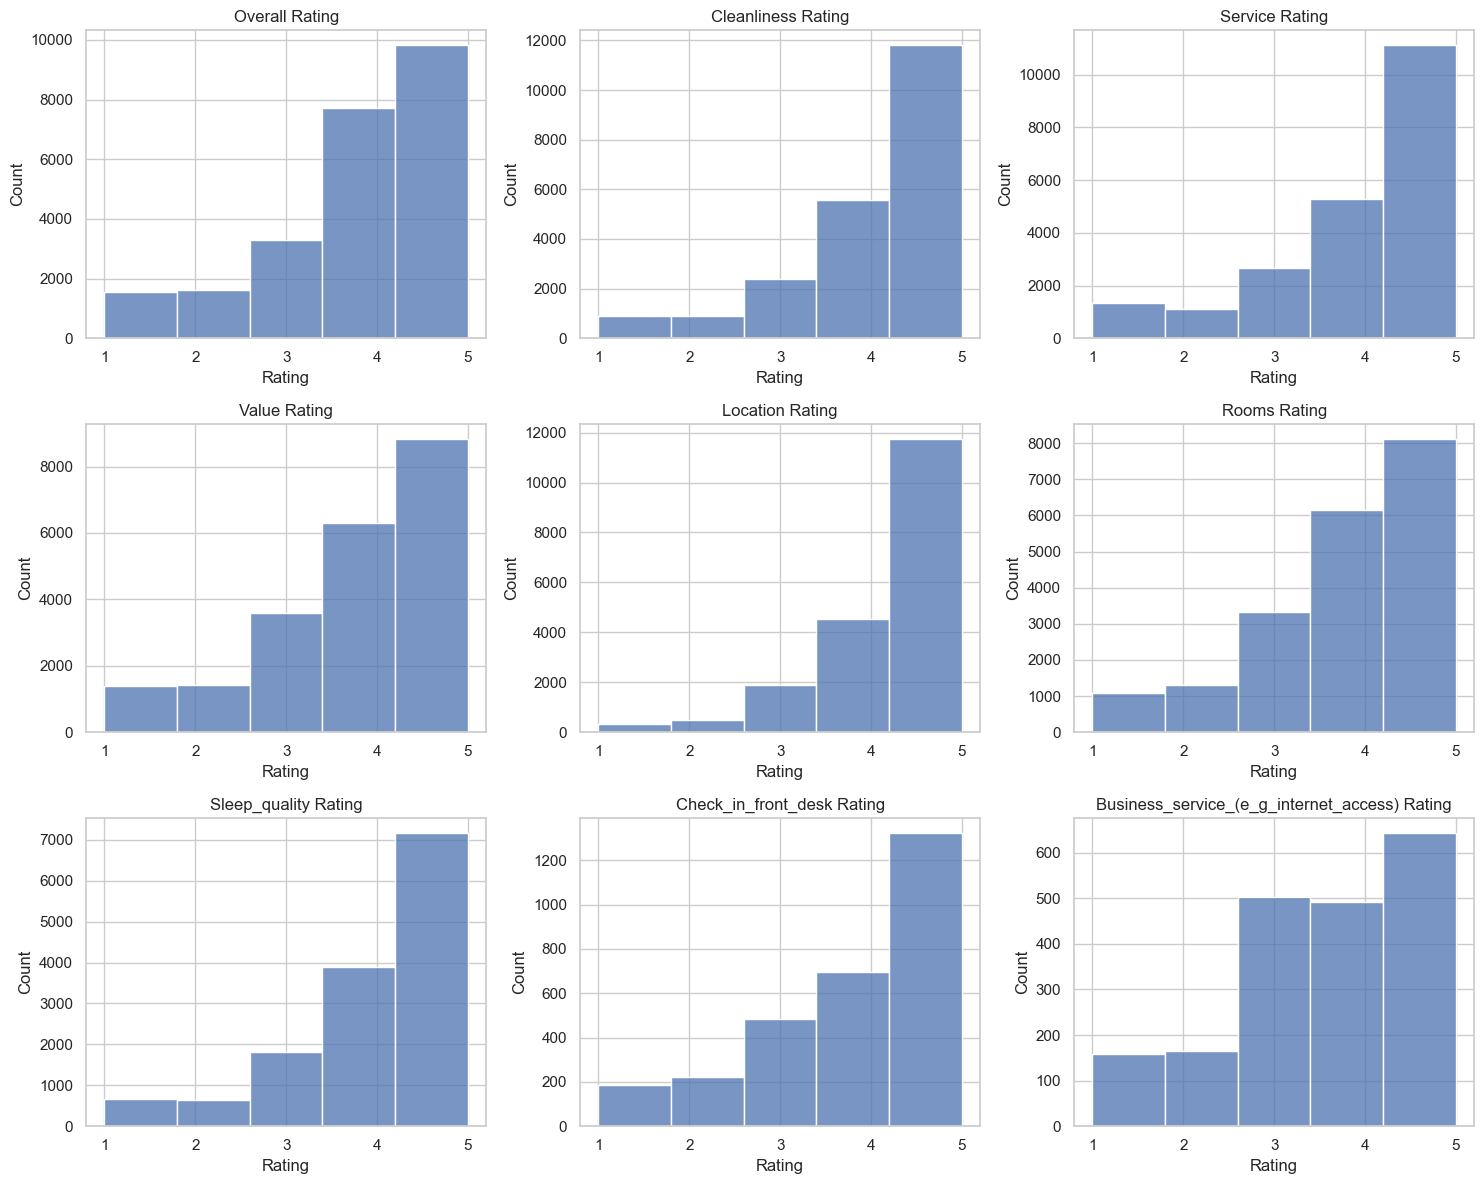

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define rating-related fields
rating_fields = ['overall', 'cleanliness', 'service', 'value', 'location', 'rooms',
                 'sleep_quality', 'check_in_front_desk', 'business_service_(e_g_internet_access)']

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12)) 

# Loop through rating fields and subplot axes
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.histplot(train_df[field].dropna(), bins=5, kde=False, ax=ax)
        ax.set_title(f'{field.capitalize()} Rating')
        ax.set_xlabel('Rating')
        ax.set_ylabel('Count')
    else:
        ax.set_visible(False)  

plt.tight_layout() 
plt.show()

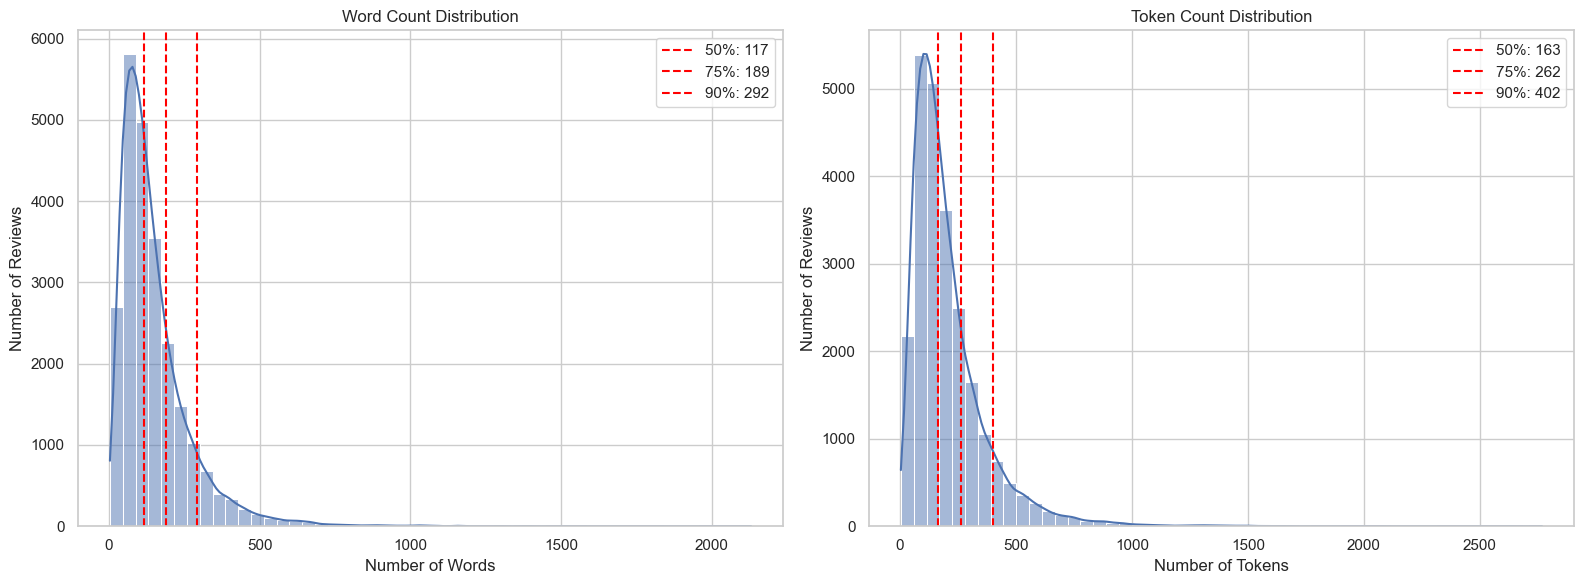

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5TokenizerFast

# Calculate number of words per review
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Load T5 tokenizer
tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# Compute token count
train_df['token_count'] = train_df['text'].apply(
    lambda x: len(tokenizer.encode(str(x), truncation=False)) if isinstance(x, str) and x.strip() else 0
)

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word count histogram with percentiles
sns.histplot(train_df['word_count'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['word_count'].quantile(p)
    axes[0].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[0].legend()

# Token count histogram with percentiles
sns.histplot(train_df['token_count'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Token Count Distribution")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['token_count'].quantile(p)
    axes[1].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[1].legend()

plt.tight_layout()
plt.show()

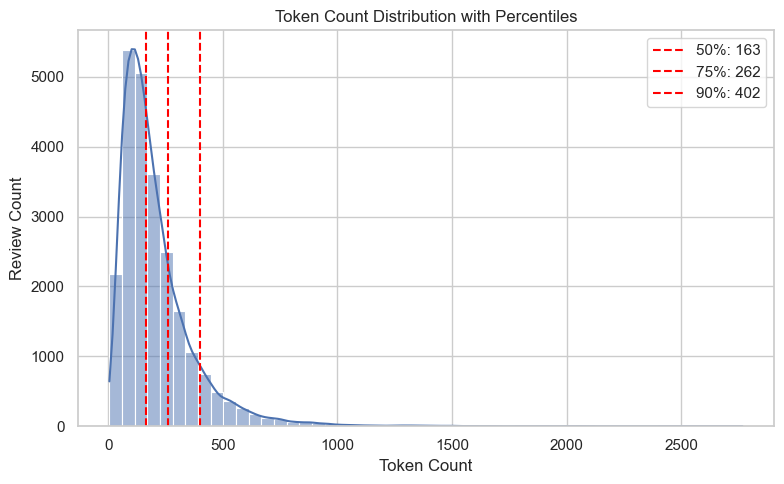

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['token_count'], bins=50, kde=True)

# Annotate useful percentiles: median, 75%, 90%
for p in [0.5, 0.75, 0.9]:
    val = train_df['token_count'].quantile(p)
    plt.axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')

plt.title("Token Count Distribution with Percentiles")
plt.xlabel("Token Count")
plt.ylabel("Review Count")
plt.legend()
plt.tight_layout()
plt.show()

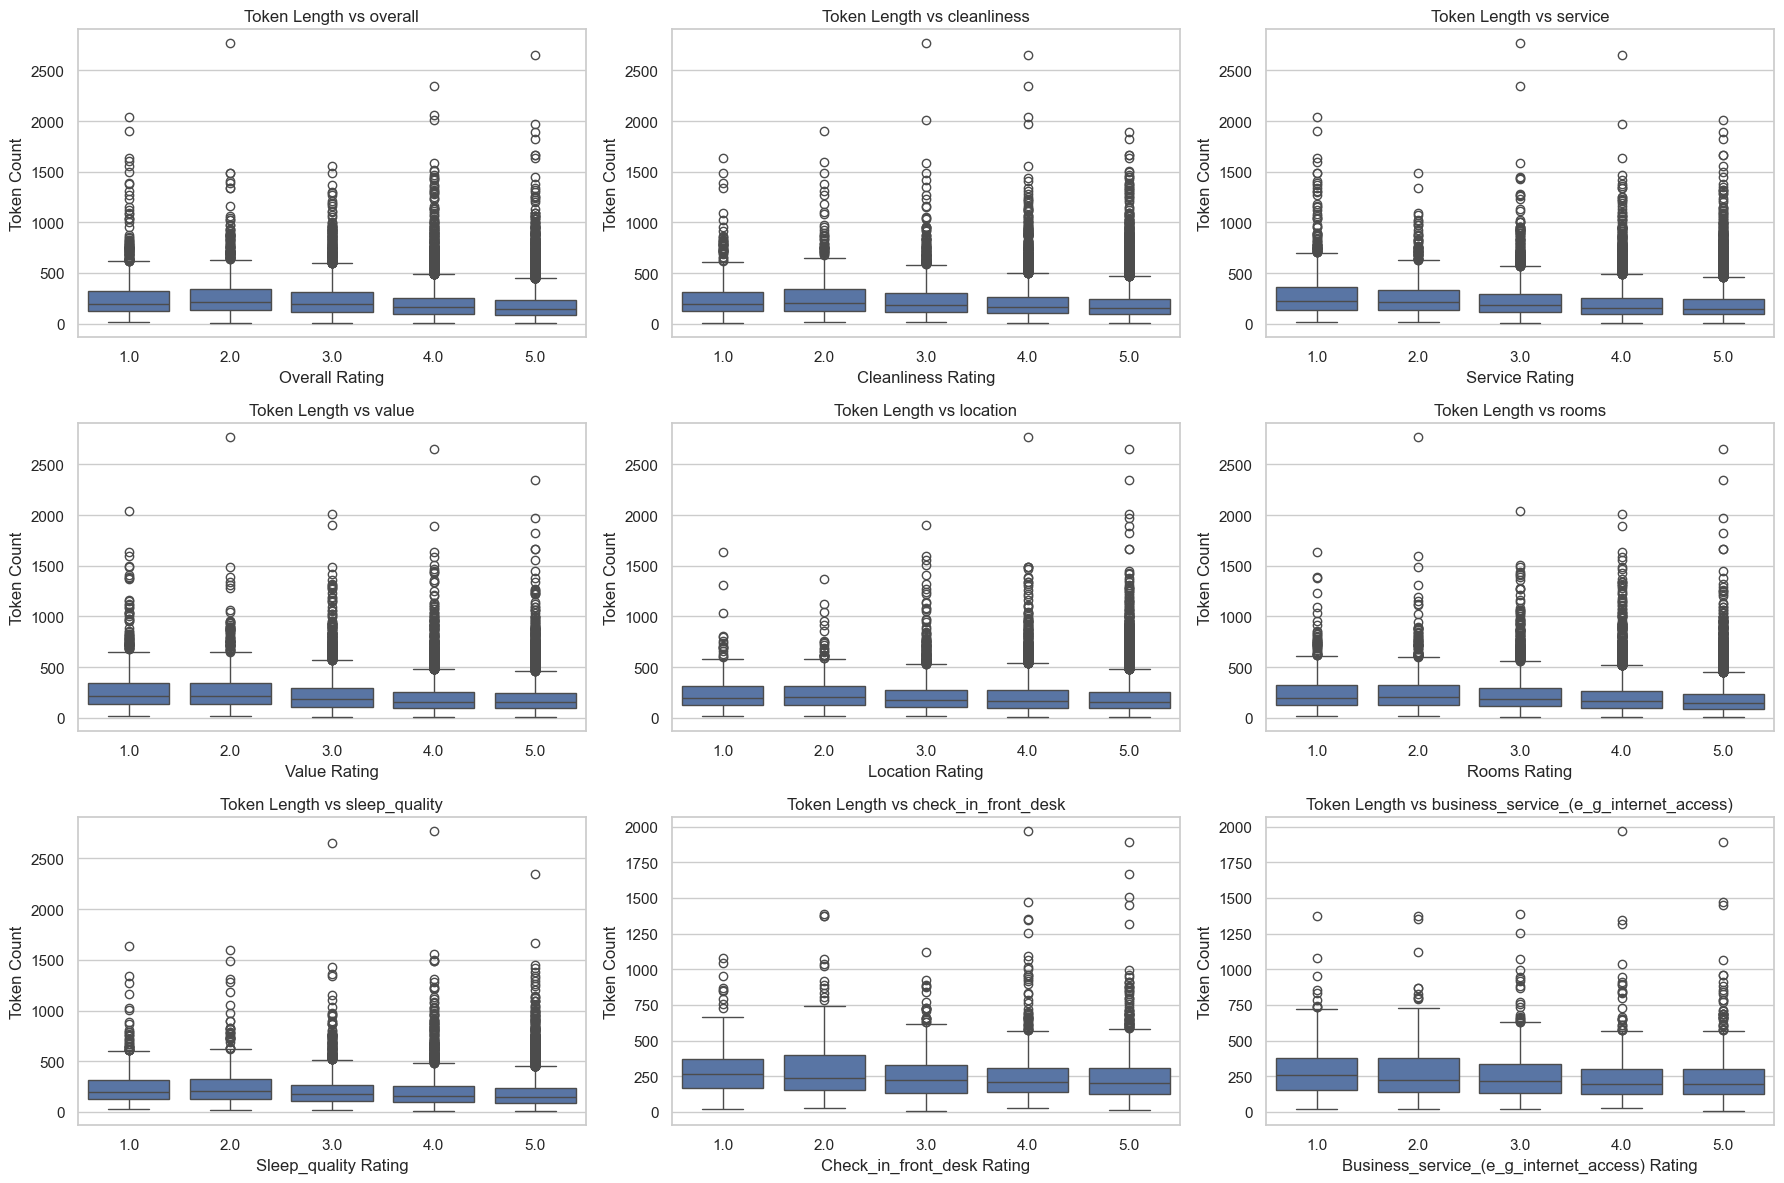

In [29]:
# Show token length per rating score via boxplot
# Create 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  

# Loop through each rating field
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.boxplot(x=field, y='token_count', data=train_df, ax=ax)
        ax.set_title(f'Token Length vs {field}')
        ax.set_xlabel(f'{field.capitalize()} Rating')
        ax.set_ylabel('Token Count')
    else:
        ax.set_visible(False) 

plt.tight_layout()
plt.show()

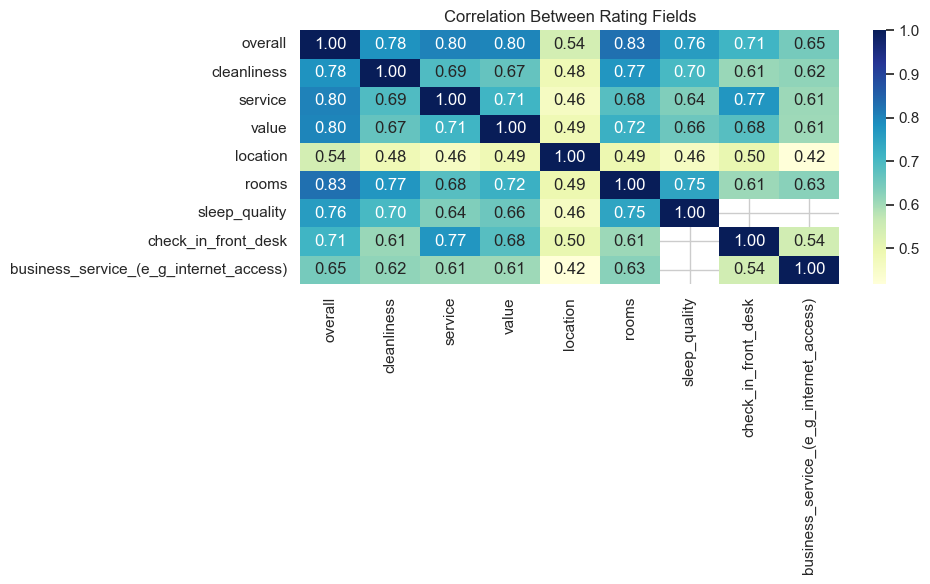

In [24]:
# Compute correlation between rating fields
plt.figure(figsize=(10, 6))
sns.heatmap(train_df[rating_fields].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Between Rating Fields")
plt.tight_layout()
plt.show()

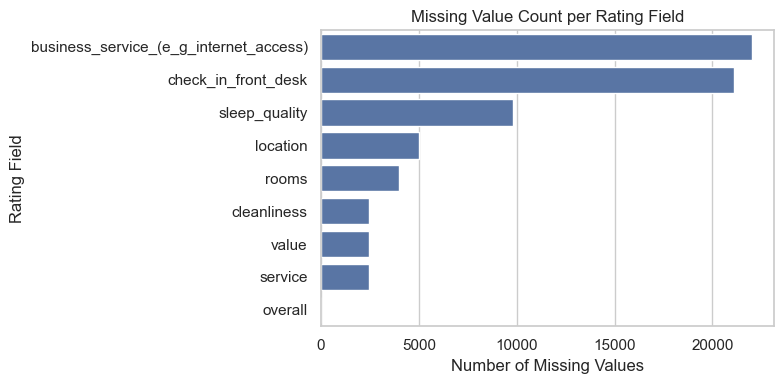

In [26]:
# Count missing values per rating field
missing_counts = train_df[rating_fields].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_counts.values, y=missing_counts.index)
plt.title("Missing Value Count per Rating Field")
plt.xlabel("Number of Missing Values")
plt.ylabel("Rating Field")
plt.tight_layout()
plt.show()

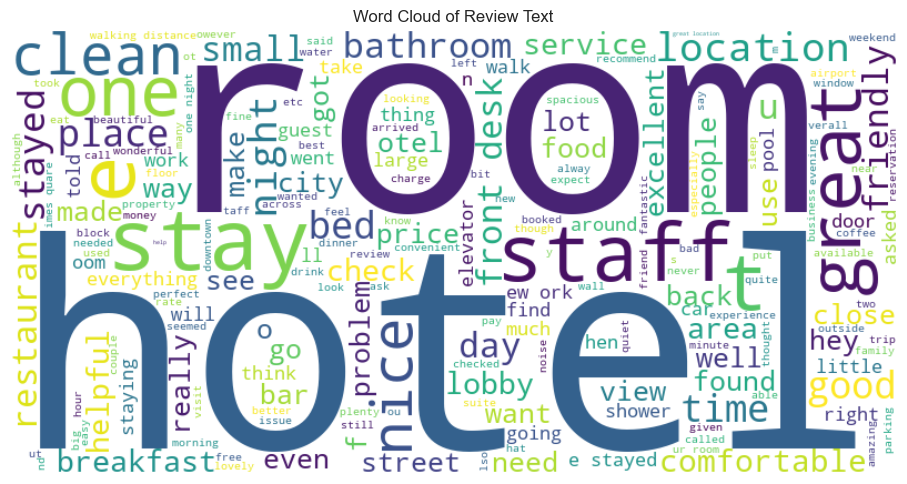

In [28]:
from wordcloud import WordCloud

# Concatenate all reviews into a single string for word cloud
all_text = " ".join(train_df['text'].dropna().tolist())

# Create and render word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Text")
plt.tight_layout()
plt.show()